In [191]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy

data_dir = pathlib.Path('Dataset_Daun')

In [192]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Image Count : ', image_count)

Image Count :  700


In [193]:
img_height = 224
img_width = 224

train_data = image_dataset_from_directory(data_dir, seed=123, image_size=(img_height, img_width), validation_split=0.2, subset='training')

Found 700 files belonging to 2 classes.
Using 560 files for training.


In [194]:
val_data = image_dataset_from_directory(data_dir, seed=123, image_size=(img_height, img_width), validation_split=0.2, subset='validation')

Found 700 files belonging to 2 classes.
Using 140 files for validation.


In [195]:
test_data = image_dataset_from_directory(data_dir, seed=123, image_size=(img_height, img_width), validation_split=None)

Found 700 files belonging to 2 classes.


In [196]:
base_model = EfficientNetB4(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [197]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 dropout_51 (Dropout)        (None, 7, 7, 1792)        0         
                                                                 
 flatten_17 (Flatten)        (None, 87808)             0         
                                                                 
 batch_normalization_68 (Bat  (None, 87808)            351232    
 chNormalization)                                                
                                                                 
 dense_68 (Dense)            (None, 32)                2809888   
                                                                 
 batch_normalization_69 (Bat  (None, 32)               128       
 chNormalization)                                    

In [198]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(verbose=1, patience=20)

In [199]:
model.compile(optimizer='adam',
            loss=SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

In [201]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_data,validation_data=val_data, epochs = 5, batch_size=256, callbacks=[lrd, es], use_multiprocessing=True)

Epoch 1/5
18/18 [==============================] - 447s 23s/step - loss: 0.5035 - accuracy: 0.7679 - val_loss: 0.1337 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 2/5
18/18 [==============================] - 297s 16s/step - loss: 0.2680 - accuracy: 0.9482 - val_loss: 0.1215 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 3/5
18/18 [==============================] - 240s 13s/step - loss: 0.1707 - accuracy: 0.9786 - val_loss: 0.1386 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 4/5
18/18 [==============================] - 242s 13s/step - loss: 0.1257 - accuracy: 0.9821 - val_loss: 0.0924 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/5
18/18 [==============================] - 269s 15s/step - loss: 0.1091 - accuracy: 0.9821 - val_loss: 0.0858 - val_accuracy: 0.9929 - lr: 0.0010


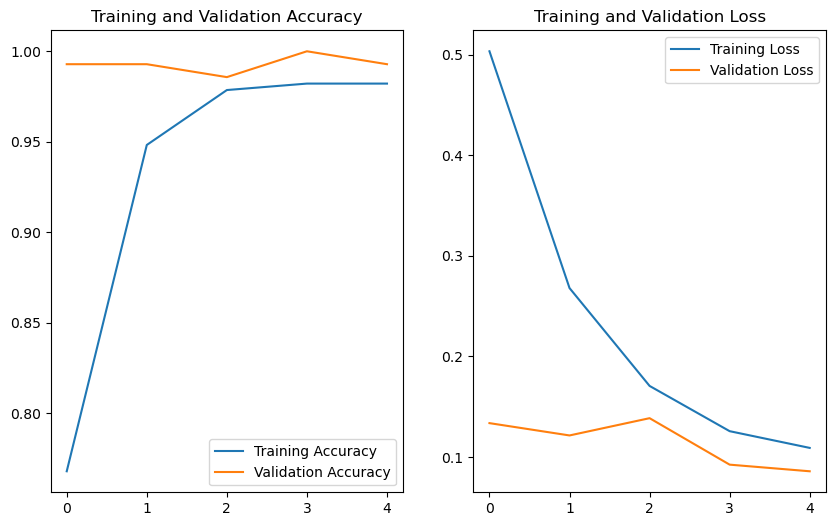

In [202]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [220]:
model.evaluate(test_data)

22/22 [==============================] - 16s 690ms/step - loss: 0.0822 - accuracy: 0.9971


[0.0821911096572876, 0.9971428513526917]

In [221]:
y_pred = model.predict(test_data)

22/22 [==============================] - 15s 664ms/step


In [203]:
labels = train_data.class_names
def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 44ms/step


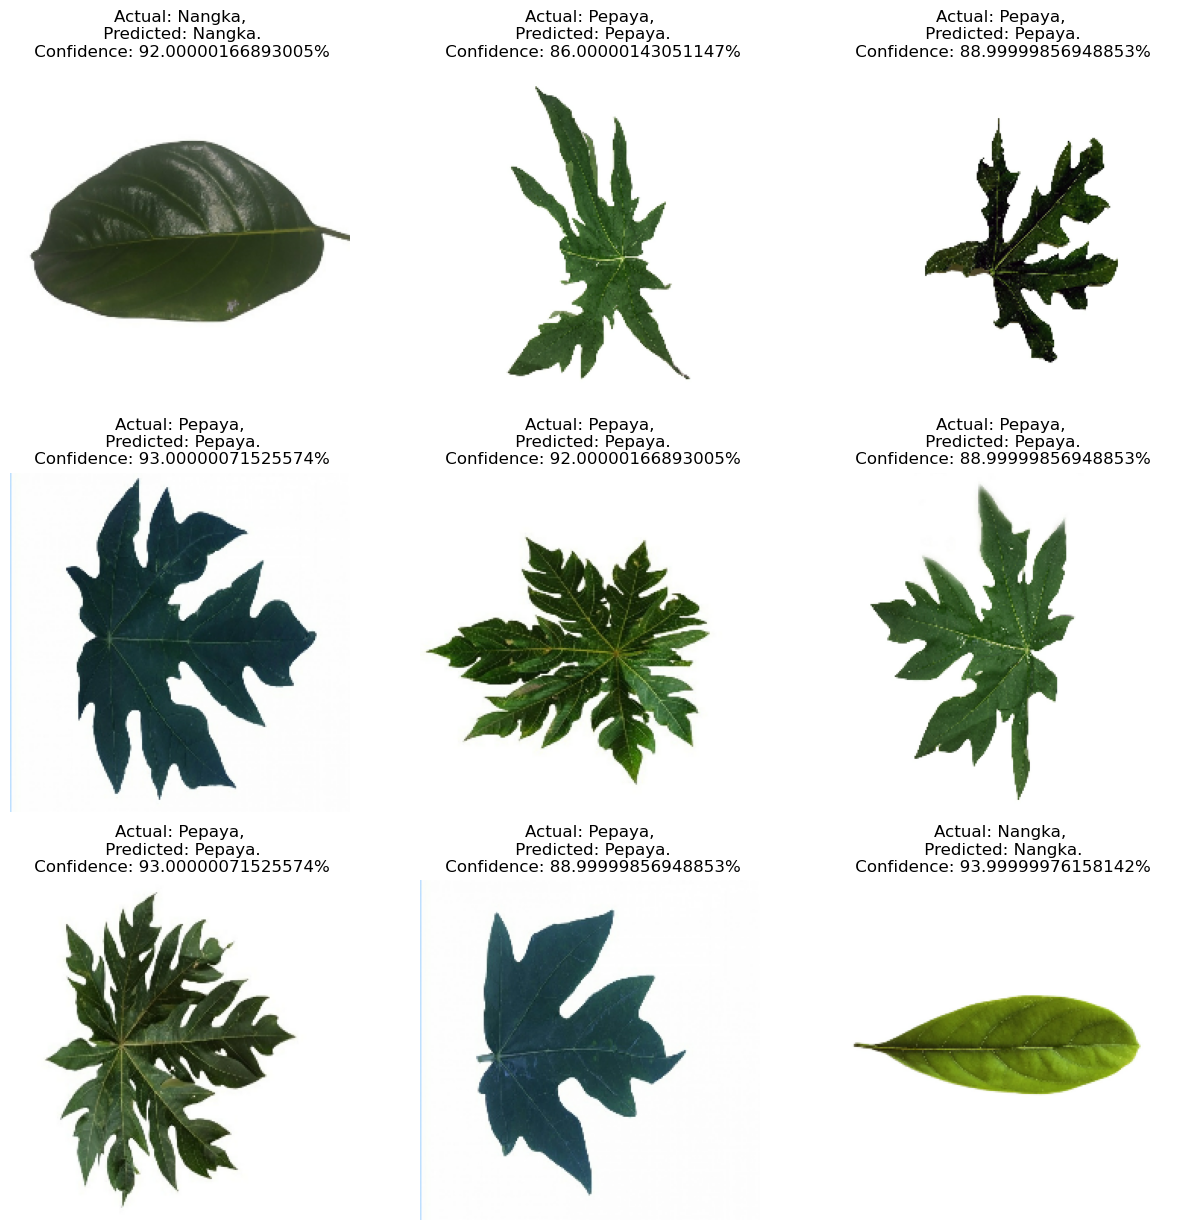

In [205]:
plt.figure(figsize=(15, 15))

for images, lbs in val_data.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence*100}%")
        
        plt.axis("off")